# ３．MCMCの中をのぞいてみよう

## 3.1 山あり谷あり

PyMCの内部構造と、マルコフ連鎖モンテカルロ法(Markov chain Monte Carlo, MCMC)の解説

### モンテカルロ法とは？
乱数を用いたシュミレーション

#### モンテカルロを用いて円周率を求めてみる
https://unit.aist.go.jp/diversity/ja/jst/teens/montecarlo.htm


#### 事前分布で遊んで見る
未知数p1、p2に対して、事前分布をUniform(0,5)とすると、作成される空間は1辺の長さが5の正方形で、曲面はその正方形の上に乗っている平面である。(一様分布を選んだので、どの点も確率は等しい)

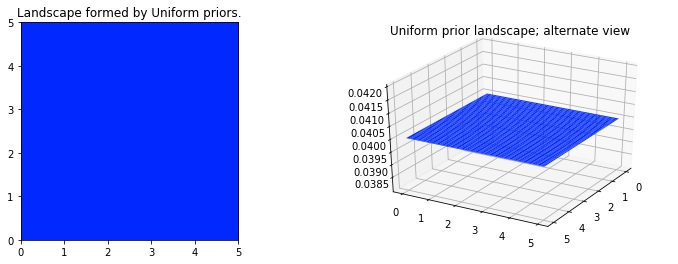

In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.") #上から見た図

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view"); #斜めからみた図


### 2つの事前分布をExp(3)とExp(10)にした場合

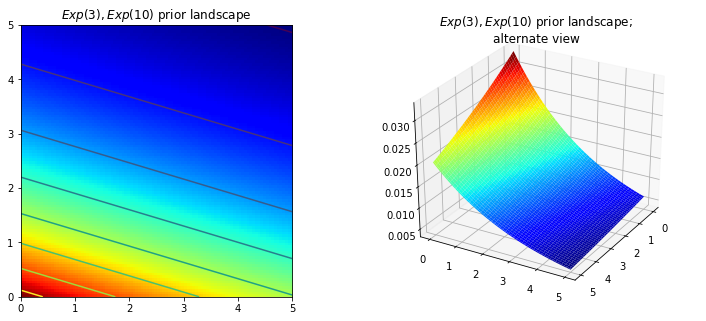

In [3]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape") #上から見た図

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view"); #斜めからみた図

色が薄いほどその位置の事前確率が高く、濃いほど、事前確率は小さい

曲面が未知数についての「事前分布」を表しているなら、得られた観測データXを取り込んだ「後」には空間はどうなるだろうか？

２つのポアソン分布に対する推論を行う。
それぞれにパラメータλが存在し、事前分布として、一様分布と指数分布を用いた場合の結果の比較をする

In [32]:
# 観測データの生成

# 観測データのサンプルサイズ
# 色々かえてみよう！ ただし(100以下にすること)
N = 1

# 真のパラメータ。もちろん本当はわからない
lambda_1_true = 1
lambda_2_true = 3

# そして２つのパラメータからデータを生成する
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# プロット
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :]) # 尤度

observed (2-dimensional,sample size = 1): [[1 7]]


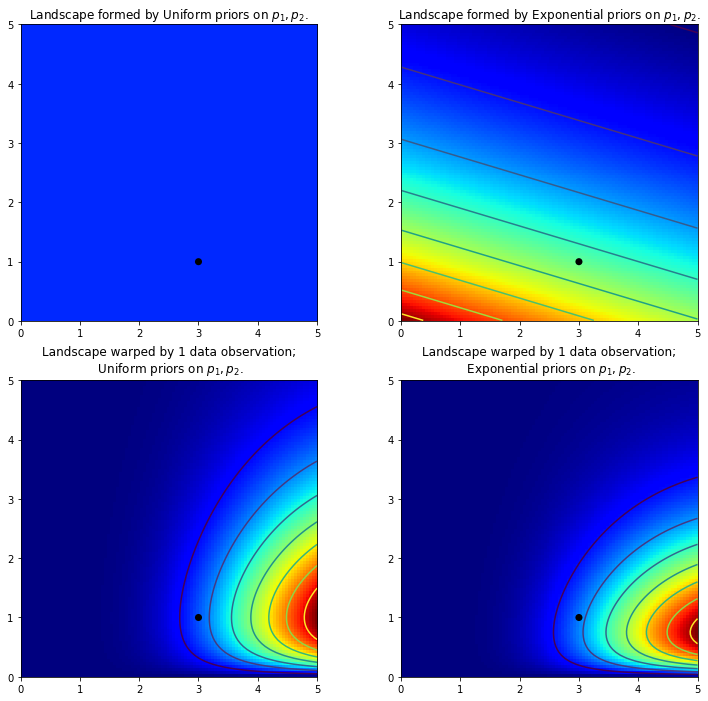

In [33]:
figsize(12.5, 12)
# 少し煩雑な matplotlibコードを用いるので要注意

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :]) #一様事前分布
plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")  #一様事前分布

plt.subplot(223)
plt.contour(x, y, M * L) #尤度と事前分布の席が事後分布となる
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)  #一様事前分布に対する事後分布
plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :]) #指数事前分布

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.") #指数事前分布

plt.subplot(224)
plt.contour(x, y, M * L) #尤度と事前分布の席が事後分布となる
plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N) #指数事前分布に対する事後分布
plt.xlim(0, 5)
plt.ylim(0, 5);


1. 左下が事前分布Uniform(0,5)が変形されてできた事後分布
2. 右下が事前分布の指数分布が変形されてできた事後分布
3. 黒点が真のパラメータの位置。


観測データは同じなのに事後分布の地形は違う！

理由
1. 事前分布が指数分布の右上は事前確率が小さい => 事後確率も小さい
2. 事前分布が一様分布の右上は事前確率が大きい => 事後確率も大きい

サンプル数が1でも事後分布の山の位置は真のパラメータに近い
Nを増やすと。。。

## 3.1.1 MCMCで地形を探索する

- 事後分布の山を求めて、事前分布の曲面を観測データが変形させて作った事後分布の地形を探査する
- しかしN次元の空間の探索は指数的に困難
- そこで登場するのがMCMC!

### MCMCの特徴
- MCMCが返すのは事後分布そのものではなく、事後分布のサンプル
- 登山に例えるなら「自分が見つけた小石が自分が探している山から持ってきた、ということはどれぐらいありそうか？」を自問することに似てる
- 「小石」がサンプル、一連のサンプルをまとめて「軌跡(trace)」と呼ぶ

#### なぜ数千もサンプルが必要？
じつはこっちのほうが効率的


## 3.1.2 MCMCを実行するアルゴリズム

1. 現在位置から始める
2. 次に移動する先の位置を提案する(近くの小石を調べる)
3. その新しい位置がデータに適しているか、事前分布に適しているか、を基準にして、新しい位置を受け入れる、または却下する(つまり小石が山からとってきたものかどうかを判定する)
4. (a)受け入れたら: 新しい位置へ移動する。ステップ1へ戻る
    (b)却下したら: 今の位置にとどまる。ステップ1へ戻る
5. 以上を何度も繰り返して、すべてを受け入れた位置を返す

モンテカルロ法は真にランダムサンプリングなので、精度も向上しないし、計算コストもかかるので、こちらのほうが良い

## 3.1.4 混合モデルの教師なりクラスタリング

In [51]:
from os import makedirs
makedirs("data", exist_ok=True) #フォルダの作成

from urllib.request import urlretrieve
#データのダウンロード
urlretrieve("https://git.io/vXt6b", "data/mixture_data.csv")

('data/mixture_data.csv', <http.client.HTTPMessage at 0x11ea65518>)

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


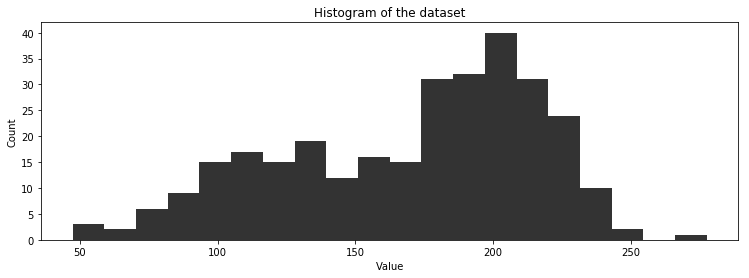

In [92]:
figsize(12.5,4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)

plt.title("Histogram of the dataset")
plt.ylim([0, None])
plt.xlabel("Value") #値
plt.ylabel("Count") #個数
print(data[:10], "...")

120と200付近で山がある。クラスタが２つある。

データ生成アルゴリズムを考える
1. 各データ点について、確率pでクラスタ0を選択する。クラスタ0を選択しなければ、クラスタ1を選択する
2. パラメタ$μ_i$と$σ_i$の正規分布から値を一つサンプリングする。$i$はステップ1で選択したクラスタ番号。
3. 繰り返す

観測データ・セットとにたようなデータを作れるのでこのモデル使う。

- ２つの正規分布を$Nor_0$、$Nor_1$。
- 平均と分散は未知で、それらを$μ_i$と$σ_i$($i=0,1$)と書く
- あるデータ点では$Nor_0$、$Nor_1$のどちらかから生成されるので確率$p$で$Nor_0$から生成されると仮定。ただし確率はわからない。
- この確率を変数pと呼び、0から1の一様分布でモデリングする

In [94]:
import pymc as pm
p = pm.Uniform("p", 0., 1.)
assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])
print("prior assignment, with p = %.2f:" % p.value) #事前確率pでのクラスタの割当
print(assignment.value[:10], "...")

prior assignment, with p = 0.83:
[1 1 0 0 0 1 0 0 0 0] ...


- ヒストグラムを見ると2つの正規分布の標準偏差はちがってるっぽい。
- まず標準偏差の値を0から100までの一様分布でモデリングする。
- 標準偏差を精度$τ$に変換する式

\begin{align}
&
& τ = \frac{1}{σ^{2}}
& 
\end{align}

PyMCでは一行で実行できる

taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2

In [95]:
taus = 1.0 / pm.Uniform("stds", 0, 33, size=2) ** 2 #stdは標準偏差
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

#以下のdeterministic関数は01のクラスタの割当を
# tausとcentersにマップする。

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print("Random assignments: ", assignment.value[:4], "...") #ランダムな割当

print("Assigned center: ", center_i.value[:4], "...") #割り当てられた中心

print("Assigned precision: ", tau_i.value[:4], "...") #割り当てられた精度

Random assignments:  [1 1 0 0] ...
Assigned center:  [ 183.03443349  183.03443349  134.47383196  134.47383196] ...
Assigned precision:  [ 0.15056206  0.15056206  0.01286405  0.01286405] ...


In [96]:
#このモデルに観測を結びつける
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

#新しいModelクラスのオブジェクトを作成する
model = pm.Model([p, assignment, taus, centers])

mcmc = pm.MCMC(model) # MCMCの探索アルゴリズムを実行するクラス
mcmc.sample(50000) # pm.sample(iterations)が空間探索させるメソッド。iterationsは実行ステップ数(反復回数)

 [-----------------100%-----------------] 50000 of 50000 complete in 19.6 sec

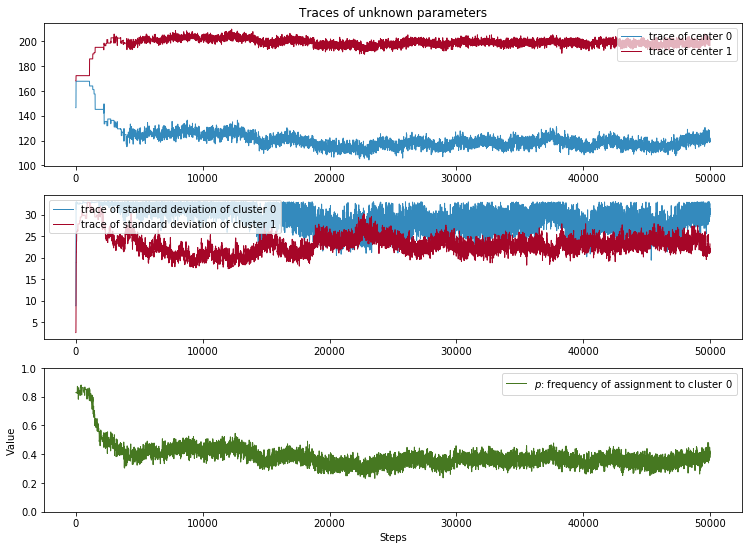

In [97]:
figsize(12.5, 9)
line_width = 1

center_trace = mcmc.trace("centers")[:]
colors = ["#348ABD", "#A60628"]

if center_trace[-1, 0] > center_trace[-1, 1] :
    # 値の大小で色の入れ替え
    colors =  ["#A60628", "#348ABD"]

plt.subplot(311)    
plt.plot(center_trace[:, 0],
         label="trace of center 0", c=colors[0], lw=line_width) #クラスタ0の中心の軌跡
plt.plot(center_trace[:, 1],
         label="trace of center 1", c=colors[1], lw=line_width) #クラスタ1の中心の軌跡
plt.title("Traces of unknown parameters") #未知パラメータの軌跡
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=line_width) #クラスタ0の標準偏差の軌跡 
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=line_width) #クラスタ1の標準偏差の軌跡 
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color="#467821", lw=line_width) #クラスタ0への割当頻度p
plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.legend();

これは未知パラメータ(クラスタ中心、精度、p)が取った値を順番にプロットしたもの。これを軌跡と呼ぶ。

1.  軌跡は収束するが、ある一点に収束するのではなく、ある分布に収束する。これがMCMCアルゴリズムの収束である
2. 最初の数千点は最終的にほしい分布とは関係がいないため、それらは推論につかえない。サンプルを使って推論する前に、それらの最初の数千点を捨てたほうが良い。
最初の数千点の期間を「バーンイン」（burn-in）と呼ぶ
3. 軌跡はランダムウォークのように見える。つまり現在の位置と、一つ前の位置には関係があることが見て取れる。このことは欲もあり、悪くもある。
今の位置と一つ前の位置は必ず何らかの関係をもっているが、その関係が強すぎると、広く空間を探索することができなくなる。


MCMCをさらに100,000ステップ実行

In [98]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 37.7 sec

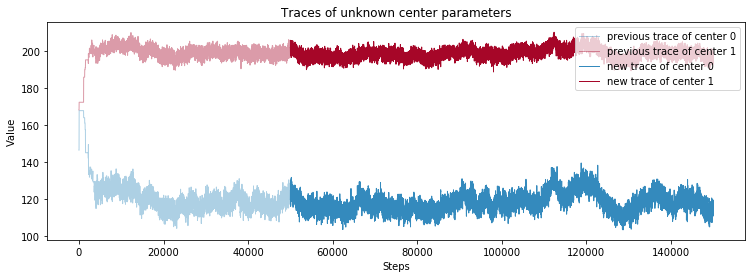

In [99]:
figsize(12.5, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=line_width, alpha=0.4, c=colors[0]) #クラスタ0の中心の最初の軌跡
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=line_width, alpha=0.4, c=colors[1])#クラスタ1の中心の最初の軌跡

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=line_width, c=colors[0]) #クラスタ0の中心の新しい軌跡
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=line_width, c=colors[1]) #クラスタ1の中心の新しい軌跡

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");
plt.ylabel("Value");


未知パラメータであるクラスタ中心の軌跡。さらに10000回サンプリングした

### クラスタを求める

未知数である、クラスタ中心と、標準偏差の事後分布を求めた

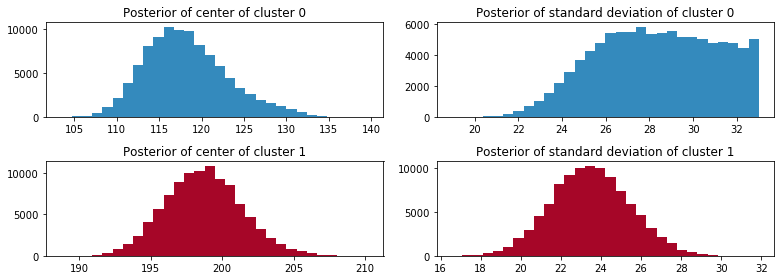

In [100]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]


_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i) #クラスタ中心の事後分布
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i) #クラスタ標準編さんの事後分布
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")


plt.tight_layout()

データ点の割当ラベルの事後分布

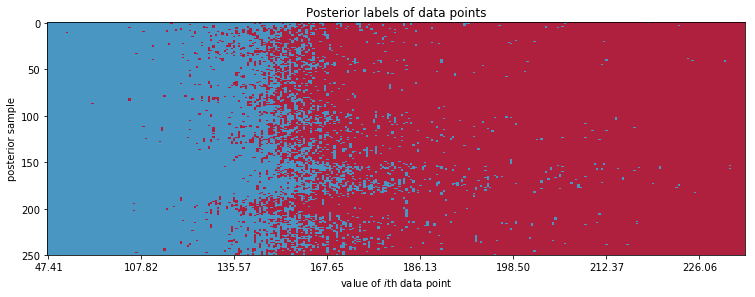

In [101]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample") #事後ラベル
plt.xlabel("value of $i$th data point") #データ点の値
plt.title("Posterior labels of data points");

150-170の間が最も確信がもてない領域。
x軸は実際のスケールではないため(ソート後のi番目のデータ点の値)、ややわかりにくい。


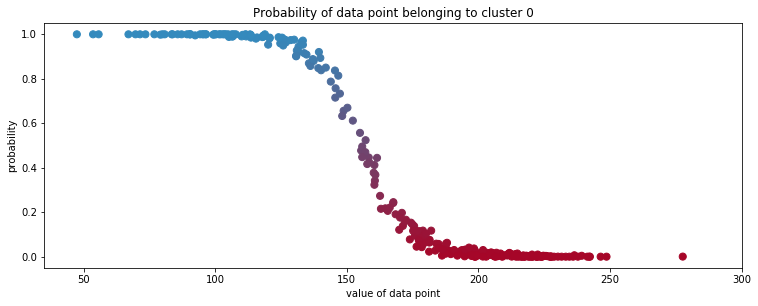

In [102]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability") #確率
plt.xlabel("value of data point"); #データ点の値

得られたのはデータをよく表す一つの正規分布ではなく、正規分布のパラメータの分布なので、事後分布の平均を使って、データを表す

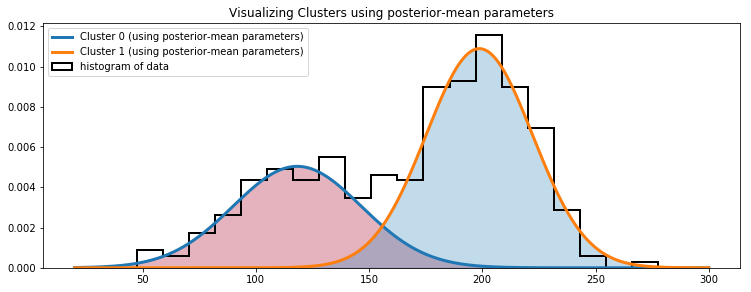

In [104]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data") #データのヒストグラム
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3) #クラスタ0(事後平均)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3) #クラスタ1(事後平均)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");
